<a href="https://colab.research.google.com/github/Femi-0/Commodities_Futures_Contracts_Generator/blob/main/Commodities_Futures_Contracts_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Import required libraries

In [3]:
!pip install hvplot
!pip install python-dotenv
!pip install newsapi-python
!pip install fsspec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 5.1 MB/s 


In [38]:
# Imports
import os
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import requests
from pandas.tseries.offsets import DateOffset
from pathlib import Path
from dotenv import load_dotenv
from newsapi import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [36]:
# Set random seeds for reproducibility
from numpy.random import seed
seed(42)

from tensorflow import random
random.set_seed(42)

In [6]:
# Load environment variables and retrieve the News API key
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")
free_news_api_key = os.getenv("free_news_api")

In [7]:
# Delete before presentation!
print(api_key)
print(free_news_api_key)

None
None


# 1. Import and prepare refrence Data:

- Historical price data
- News data

## 1.1 Historical price data

In [8]:
# function to prepare historical data for strategy

def prepare_data(path,label):
  # Import the OHLCV dataset into a Pandas Dataframe
  ohlcv_df = pd.read_csv(
    Path(path), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
    
  )

  #initiate signal
  signals_df = pd.DataFrame()

  # Filter the date index and close columns
  signals_df[label+"_"+"Close"] = ohlcv_df.loc[:, ["Close"]]

  #remove non-sum characters and correct formatting
  signals_df[label+"_"+"Close"] = signals_df[label+"_"+"Close"].str.replace("$","",)
  signals_df[label+"_"+"Close"]= signals_df[label+"_"+"Close"].str.replace(",","",)
  signals_df[label+"_"+"Close"] = signals_df[label+"_"+"Close"].astype('float')

  # Use the pct_change function to generate returns from close prices
  signals_df[label+"_"+"Returns"] = signals_df[label+"_"+"Close"].pct_change()

  # Drop all NaN values from the DataFrame
  signals_df = signals_df.dropna()

  return signals_df

## 1.2 News data

### 1.2.1 Collect news articles and preprocess(filter stop words etc)

# 2. Generating Trading Signals using:
 
- short and long window SMA values
- NLP sentiment analysis
- Bollinger Bands

## 2.1 Prepare short and long window SMA signals

In [15]:
# apply signals strategy
def apply_sma_signal(signal_df,short_window,long_window,label):

  # Initialize new columns
  signal_df[label+"_"+'SMA_Slow'] = 0.0
  signal_df[label+"_"+'SMA_Fast'] = 0.0
  signal_df[label+"_"+"Signal"] = 0.0

  # Generate the fast and slow simple moving averages (fast and slow, respectively)
  signal_df[label+"_"+'SMA_Fast'] = signal_df[label+"_"+"Close"].rolling(window=short_window).mean()
  signal_df[label+"_"+'SMA_Slow'] = signal_df[label+"_"+"Close"].rolling(window=long_window).mean()

  signal_df = signal_df.dropna()

  # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
  signal_df.loc[(signal_df[label+"_"+"Returns"] >= 0), label+"_"+"Signal"] = 1

  # When Actual Returns are less than 0, generate signal to sell stock short
  signal_df.loc[(signal_df[label+"_"+"Returns"] < 0), label+"_"+"Signal"] = -1

  return signal_df


## 2.2 Prepare Bollinger bands signals

In [10]:
# apply bollinger strategy
def apply_bllg_signal(signal_df,sma,label,):

  # Initialize new columns
  signal_df[label+"_"+'SMA'] = 0.0
  signal_df[label+"_"+'ST_DV'] = 0.0
  signal_df[label+"_"+'upper_bnd'] = 0.0
  signal_df[label+"_"+'lower_bnd'] = 0.0
  signal_df[label+"_"+"Signal"] = 0.0

  # Generate the simple moving averages
  signal_df[label+"_"+'SMA'] = signal_df[label+"_"+"Close"].rolling(window=sma).mean()

  signal_df[label+"_"+'ST_DV'] = signal_df[label+"_"+"Close"].rolling(window=sma).std()

  signal_df = signal_df.dropna()

  # Generate upper-band
  signal_df[label+"_"+'upper_bnd'] = signal_df[label+"_"+'SMA'] + signal_df[label+"_"+'ST_DV'] * 2

  # Generate lower-band
  signal_df[label+"_"+'lower_bnd'] = signal_df[label+"_"+'SMA'] - signal_df[label+"_"+'ST_DV'] * 2

  # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
  signal_df.loc[(signal_df[label+"_"+"Close"] < signal_df[label+"_"+"lower_bnd"]), label+"_"+"Signal"] = 1

  # When Actual Returns are less than 0, generate signal to sell stock short
  signal_df.loc[(signal_df[label+"_"+"Close"] > signal_df[label+"_"+"upper_bnd"]), label+"_"+"Signal"] = -1

  return signal_df

## 2.3 Prepare NLP sentiment analysis signals

## 2.4 Assess signals algorithim

In [11]:
# Evaluate trade algorithim and include trade costs

def evaluate_algo(signals_df,trade_cost,label):
  # Calculate after transaction cost on returns
  cost_per_trade = trade_cost
  signals_df[label+"_"+"Trade_Cost"] = signals_df["platinum_Signal"] * cost_per_trade
  signals_df[label+"_"+"Return_after_Trade_Cost"] = signals_df[label+"_"+"Returns"] - signals_df[label+"_"+"Trade_Cost"]
  return signals_df

# generate plot

def generate_eval_plot(signals_df,label):
  return(
      display ((signals_df[label+"_"+"Return_after_Trade_Cost"]).cumsum().plot()),
      display ((1+signals_df[label+"_"+"Return_after_Trade_Cost"]).cumprod().plot())
  )

#generate annualized sharpe ratios

def get_sharpe_ratios(signals_df,label):
  annualized_return = signals_df[label+"_"+"Return_after_Trade_Cost"].mean() * 252 
  annualized_std = signals_df[label+"_"+"Return_after_Trade_Cost"].std() * np.sqrt(252)
  return annualized_return/annualized_std

# 3. Apply ML and deep learning methods:

- Preprocess Signals df
  - SMA Short & long windows
  - NLP
  - Bollinger bands
- RNN
- SVM
- AdaBoost
- Backtest methods and display portfolio returns

## 3.1 Preprcessing Signals

### 3.1.1 SMA Long & Short Windows

In [25]:
# signals data preprocessing

def preprocess_sma_signals(signals_df,label,offset_years):
  # Prepare the data

  ## create features & target sets
  X = signals_df[[label+"_"+"SMA_Slow",label+"_"+"SMA_Fast"]].copy()
  y = signals_df[[label+"_"+"Signal"]].copy()

  #sort ascending
  X.sort_index(inplace=True)
  y.sort_index(inplace=True)

  #split data into train, test

  # Select the start of the training period
  training_begin = X.index.min().date()
  # Select the ending period for the training data with an offset of 3 months
  training_end = (X.index.min() + DateOffset(years=offset_years)).date()

  # Generate the X_train and y_train DataFrames
  X_train = X.loc[training_begin:training_end]
  y_train = y.loc[training_begin:training_end]

  # Generate the X_test and y_test DataFrames
  X_test = X.loc[training_end:]
  y_test = y.loc[training_end:]

  #scale data

  # Create a StandardScaler instance
  scaler = MinMaxScaler()
  
  # Apply the scaler model to fit the X-train data
  X_scaler = scaler.fit(X_train)
  
  # Transform the X_train and X_test DataFrames using the X_scaler
  X_train_scaled = X_scaler.transform(X_train)
  X_test_scaled = X_scaler.transform(X_test)

  return (X,y,X_train,y_train,X_test,y_test,X_train_scaled,X_test_scaled)

### 3.1.2 Bollinger Bands

In [35]:
def preprocess_bllg_signals(signals_df,label,offset_years):
  # Prepare the data

  ## create features & target sets
  X = signals_df[[label+"_"+"upper_bnd",label+"_"+"lower_bnd"]].copy()
  y = signals_df[[label+"_"+"Signal"]].copy()

  #sort ascending
  X.sort_index(inplace=True)
  y.sort_index(inplace=True)

  #split data into train, test

  # Select the start of the training period
  training_begin = X.index.min().date()
  # Select the ending period for the training data with an offset of 3 months
  training_end = (X.index.min() + DateOffset(years=offset_years)).date()

  # Generate the X_train and y_train DataFrames
  X_train = X.loc[training_begin:training_end]
  y_train = y.loc[training_begin:training_end]

  # Generate the X_test and y_test DataFrames
  X_test = X.loc[training_end:]
  y_test = y.loc[training_end:]

  #scale data

  # Create a StandardScaler instance
  scaler = MinMaxScaler()
  
  # Apply the scaler model to fit the X-train data
  X_scaler = scaler.fit(X_train)
  
  # Transform the X_train and X_test DataFrames using the X_scaler
  X_train_scaled = X_scaler.transform(X_train)
  X_test_scaled = X_scaler.transform(X_test)

  return (X,y,X_train,y_train,X_test,y_test,X_train_scaled,X_test_scaled)

### 3.1.3 NLP Sentiments

## 3.2 Apply SVM for prediction

## 3.3 Apply AdaBoost for prediction

## 3.4 Apply RNN for prediction

## 3.5 Backtest methods and display portfolio returns

---

# End of notebook

---

---
# Live area below
---

In [18]:
platinum_df = prepare_data("/content/Historical_commodities_data/AmarkPriceHistory_platinum.csv","platinum")
sma_platinum_df = apply_sma_signal(platinum_df,10,80,"platinum")
bllg_platinum_df = apply_bllg_signal(platinum_df,20,"platinum")
display(sma_platinum_df.head())
display(bllg_platinum_df.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/di

,platinum_Close,platinum_Returns,platinum_SMA,platinum_ST_DV,platinum_upper_bnd,platinum_lower_bnd,platinum_Signal
Date,,,,,,,
2022-05-11,996.91,0.051548,975.3085,30.586536,1036.481572,914.135428,0.0
2022-05-10,967.85,-0.029150,972.7010,28.743425,1030.187851,915.214149,0.0
2022-05-09,963.21,-0.004794,969.0115,24.474450,1017.960399,920.062601,0.0
2022-05-06,965.75,0.002637,966.1985,21.056955,1008.312411,924.084589,0.0
2022-05-05,985.75,0.020709,964.0360,15.843339,995.722679,932.349321,0.0


In [19]:
sma_platinum_df.head()

,platinum_Close,platinum_Returns,platinum_SMA_Slow,platinum_SMA_Fast,platinum_Signal
Date,,,,,
2022-02-16,1066.92,-0.025181,1006.289250,1073.754,-1.0
2022-02-15,1030.09,-0.034520,1006.415375,1070.820,-1.0
2022-02-14,1034.91,0.004679,1006.389250,1069.326,1.0
2022-02-11,1037.38,0.002387,1006.581375,1066.804,1.0
2022-02-10,1031.67,-0.005504,1006.614750,1063.599,-1.0


In [41]:
X,y,X_train,y_train,X_test,y_test,X_train_scaled,X_test_scaled = preprocess_sma_signals(sma_platinum_df,"platinum",7)

In [ ]:
X,y,X_train,y_train,X_test,y_test,X_train_scaled,X_test_scaled = preprocess_bllg_signals(bllg_platinum_df,"platinum",7)

In [42]:
X[:5]

,platinum_SMA_Slow,platinum_SMA_Fast
Date,,
2012-06-08,1487.79375,1463.95
2012-06-11,1490.66250,1464.25
2012-06-12,1493.63125,1464.70
2012-06-13,1496.40000,1461.90
2012-06-14,1499.19375,1456.60


## NLP - WIP

In [16]:
# Create the newsapi client
# newsapi = NewsApiClient(api_key=api_key)

In [49]:
news_url = "https://free-news.p.rapidapi.com/v1/search"

In [70]:
search_start_date = "2012-06-08"

In [71]:
news_querystring = {"q":"Platinum","lang":"en","from":search_start_date}

In [47]:
headers = {
	"X-RapidAPI-Key": free_news_api_key,
	"X-RapidAPI-Host": "free-news.p.rapidapi.com"
}

In [72]:
free_news_resp = requests.request("GET", news_url, headers=headers, params=news_querystring)

In [73]:
free_news_en = free_news_resp.json()

In [65]:
# free_news_df = pd.read_json(free_news_en.articles)

# free_news_df.head()

In [28]:
# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
# news_en = newsapi.get_everything(
#     q="platinum",
#     language="en",
#     from_param=search_start_date
# )

# # Show the total number of news
# news_en["totalResults"]

11049

In [66]:
# Function to create a dataframe for news
def create_df(news):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["topic"]
            text = article["summary"]
            date = article["published_date"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [24]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [76]:
free_news_en

{'error_code': 'UnsupportedParameter',
 'message': "Apply to be a contributor (https://free-docs.newscatcherapi.com/#contributors) in order to filter on these parameters['from']",
 'status': 'error'}

In [74]:
free_news_df = create_df(free_news_en["articles"])

KeyError: ignored

In [69]:
free_news_df.tail()

,title,description,text,date
20,Photos show how royal fans dressed to the nine...,news,Royal fans across the UK used the Union Jack a...,2022-06-06
21,Princesses Beatrice and Eugenie's Platinum Jub...,news,"Published: 09:15 EDT, 6 June 2022 | Updated: 0...",2022-06-06
22,Princess Eugenie's 1-year-old son gave Prince ...,news,"August Brooksbank, the son of Princess Eugenie...",2022-06-06
23,Alicia Keys Shares Details of Platinum Jubilee...,news,Alicia Keys performs during the BBC Platinum P...,2022-06-07
24,Unseen Kate Middleton moment melts hearts,news,Prince Louis wasn't the only royal who needed ...,2022-06-07


In [38]:
# platinum_news_df = create_df(news_en["articles"])

# platinum_news_df.head()

,title,description,text,date
0,Quiz of the week: What's in the Platinum Jubil...,How closely have you been paying attention to ...,It's the weekly news quiz - how closely have y...,2022-05-19
1,Platinum Jubilee: Festivities continue with Pa...,The star-studded concert will also see Prince ...,"By James ClarkeBBC News\r\nImage caption, The ...",2022-06-04
2,Who's who in the House of Windsor: Queen Eliza...,Britain's Queen Elizabeth II appeared Thursday...,"By CNN Staff\r\nUpdated 1:19 PM ET, Thu June 2...",2022-06-02
3,Russia risks speed up automakers' switch from ...,Automakers are accelerating efforts to use les...,"LONDON, May 16 (Reuters) - Automakers are acce...",2022-05-15
4,Platinum Jubilee: Who is on - and off - the wo...,The Queen is due to appear on the balcony of B...,By Sean CoughlanRoyal correspondent\r\nImage s...,2022-05-31


In [85]:
# Sentiment scores dictionaries
title_sent = {
    "title_sent": [],
}
text_sent = {
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in platinum_news_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
platinum_news_df = platinum_news_df.join(title_sentiment_df).join(text_sentiment_df)
platinum_news_df = platinum_news_df.drop(columns=["description"],axis=1)
platinum_news_df.set_index('date',inplace=True)
platinum_news_df.sort_index(inplace=True)

platinum_news_df.head()

NameError: ignored

In [84]:
del(platinum_news_df)

In [105]:
get_sharpe_ratios(platinum_df,"platinum")

0.2378782076237487

## Continued

## Apply RNN

In [59]:
# complie and fit LSTM RNN

def compile_fit_RNN_model(X_train,y_train,number_units,dropout_fraction,optimizer,loss,epochs,batch_size,verbose):
  
  #prepare inputs
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  y_train = y_train.values
  
  # Define the LSTM RNN model.
  model = Sequential()

  number_units = number_units
  dropout_fraction = dropout_fraction

  # Layer 1
  model.add(LSTM(
      units=number_units,
      return_sequences=True,
      input_shape=(X_train.shape[1], 1))
      )
  model.add(Dropout(dropout_fraction))
  # Layer 2
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 3
  model.add(LSTM(units=number_units))
  model.add(Dropout(dropout_fraction))
  # Output layer
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer=optimizer, loss=loss)

  # Train the model
  model.fit(X_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=verbose)

  return model

In [66]:
# evalute and make predictions with models

def evalute_predict_RNN_model(model,X_test, y_test,df):

  #reshape x_test
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
  y_test = y_test.values.reshape(-1, 1)

  # Evaluate the model
  model_eval = model.evaluate(X_test, y_test)

  # Make some predictions
  model_predicted = model.predict(X_test)

  # Create a DataFrame of Real and Predicted values
  stocks = pd.DataFrame({
      "Actual": y_test.ravel(),
      "Predicted": model_predicted.ravel()
  }, index = df.index[-len(y_test): ]) 

  return (model_eval,model_predicted,stocks)

In [71]:
bllg_RNN_model = compile_fit_RNN_model(X_train_scaled,y_train,20,0.2,"opt","categorical_crossentropy",50,1,1)

ValueError: ignored

In [67]:
bllg_RNN_model_eval, bllg_RNN_model_predicted, bllg_RNN_model_df = evalute_predict_RNN_model(bllg_RNN_model,X_train_scaled,y_train,bllg_platinum_df)

55/55 [==============================] - 2s 2ms/step - loss: 0.9989


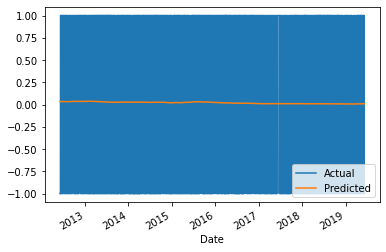

In [68]:
bllg_RNN_model_df.plot()

In [69]:
bllg_RNN_model_eval

0.9989393353462219

In [70]:
bllg_RNN_model_predicted[:5]

array([[0.00854546],
       [0.00851739],
       [0.00848729],
       [0.00848674],
       [0.00850751]], dtype=float32)

In [50]:
X_train_scaled[:5]

array([[0.82986858, 0.73148549],
       [0.83341479, 0.73181031],
       [0.83708461, 0.73229753],
       [0.8405072 , 0.72926592],
       [0.8439607 , 0.7235275 ]])

In [52]:
X_train_scaled.reshape((X_train.shape[0], X_train.shape[1], 1))

array([[[0.82986858],
        [0.73148549]],

       [[0.83341479],
        [0.73181031]],

       [[0.83708461],
        [0.73229753]],

       ...,

       [[0.06240089],
        [0.01855565]],

       [[0.06369019],
        [0.0196557 ]],

       [[0.06491738],
        [0.02017324]]])

In [54]:
y_train.values[:5]

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.]])

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))